In [1]:
import torch
import torch.nn as nn

import source
from source import propagator

%matplotlib widget
import matplotlib.pyplot as plt

## Подготовка

In [2]:
# Для повышения точности операции умножения допускается изменение
# параметров array_size и vector_size.
# Минимальное значение array_size для коректной работы системы 4096.

config = source.Config(array_size = 4096,
                       scale_by_x = 2,
                       vector_size = 4)

# Для моделирования распространения света в свободном пространстве
# доступно 4 оператора.
# Sinc является наиболее точным оператором распространения.

propagator_operator = propagator.Propagator_sinc_operator()
prop = propagator.Propagator(operator = propagator_operator,
                  config = config)
mul = source.OpticalMul(prop, config)

In [3]:
distributed_mul = source.DataParallel(mul, output_device = 'cpu')

## Пример работы с вещественными матрицами

In [4]:
mat1 = torch.rand((2, 1, 3, 4)) * 100
mat2 = torch.rand((2, 4, 3)) * 100

In [5]:
res = distributed_mul(mat1, mat2)**2

In [6]:
fr = (mat1 @ mat2)**2

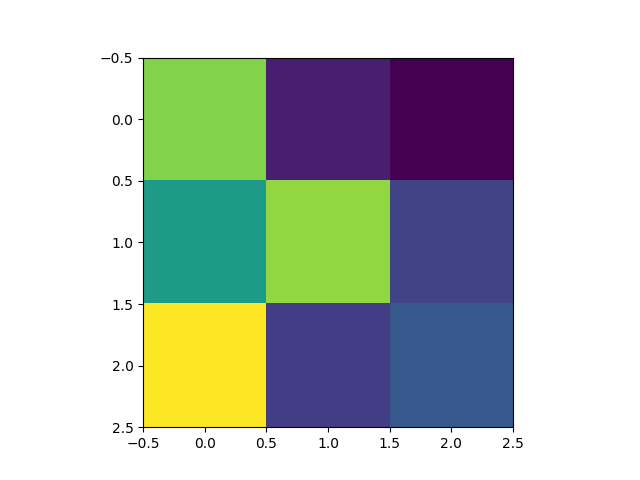

In [7]:
plt.figure()
plt.imshow(res[0, 0])

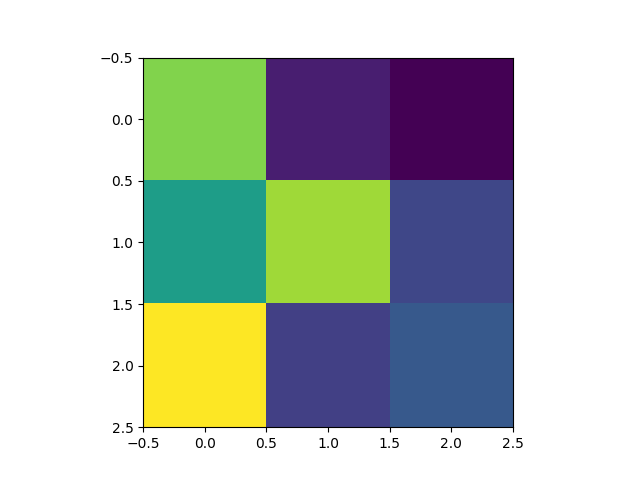

In [8]:
plt.figure()
plt.imshow(fr[0, 0])

In [9]:
CKO = (((fr / fr.mean() - res / res.mean())**2).sum() / fr.size(0))**0.5 * 100

In [10]:
CKO

tensor(4.0732)

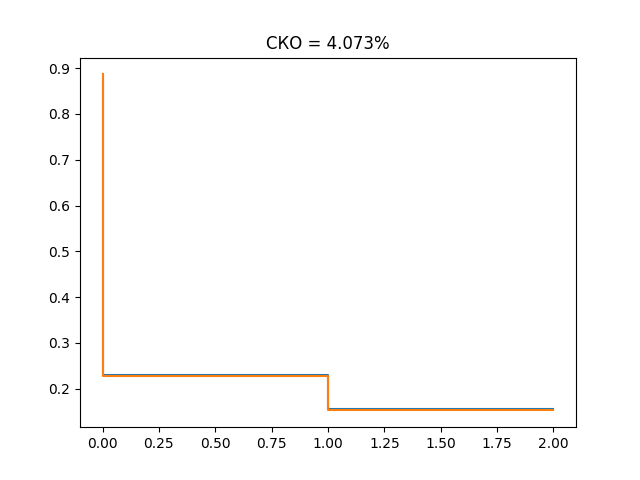

In [11]:
plt.figure()
plt.step(range(fr.size(-1)), fr[0, 0, 0] / fr.mean())
plt.step(range(res.size(-1)), res[0, 0, 0]/ res.mean())
plt.title(f"СКО = {CKO :.3f}%");

## Пример работы с комплексными матрицами

In [12]:
config = source.Config(scale_by_x = 2,
                       vector_size = 16)

propagator_operator = propagator.Propagator_sinc_operator()
prop = propagator.Propagator(operator = propagator_operator,
                  config = config)
mul = source.OpticalMul(prop, config)

In [13]:
distributed_mul = source.DataParallel(mul, output_device = 'cpu')

In [14]:
mat1 = torch.rand(1, 1, 10, 16)
mat2 = torch.exp(1j * torch.rand((1, 1, 16, 11)))

In [15]:
res = distributed_mul(mat1, mat2)[0, 0]
fr = (mat1.cfloat() @ mat2)[0, 0].abs()

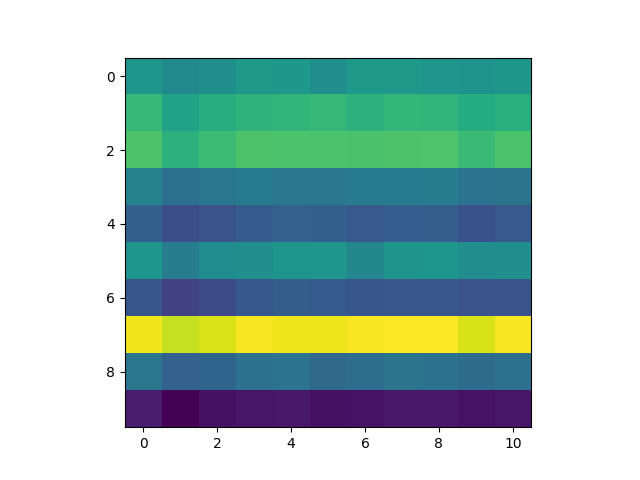

In [16]:
plt.figure()
plt.imshow(res)

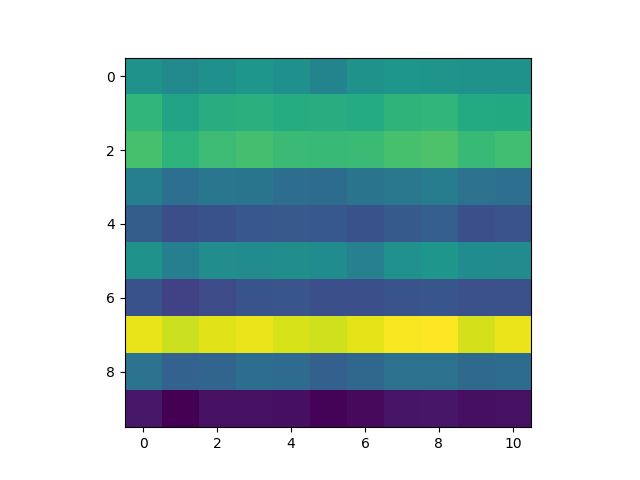

In [17]:
plt.figure()
plt.imshow(fr)

In [18]:
CKO = (((fr / fr.mean() - res / res.mean())**2).sum() / fr.size(0))**0.5 * 100

In [19]:
CKO

tensor(2.2230)

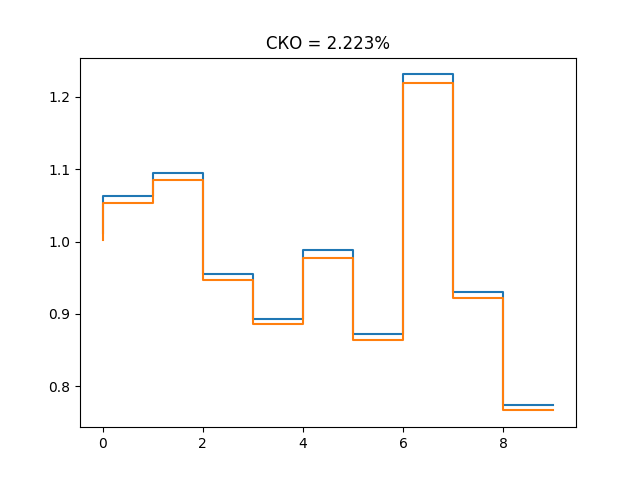

In [20]:
plt.figure()
plt.step(range(fr.size(0)), fr[:, 1] / fr.mean())
plt.step(range(res.size(0)), res[:, 1]/ res.mean())
plt.title(f"СКО = {CKO :.3f}%");